In [1]:
import os
import numpy as np
import pandas as pd 
from pingouin import compute_effsize 

%matplotlib inline
import seaborn as sns 
from matplotlib import pyplot as plt

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_tables_path = lambda folders, fname: os.path.normpath('../local_data/' + '/'.join(folders) + '/' + fname)
get_figure_path = lambda fname: os.path.normpath('../local_data/figures/' + fname)

In [3]:
file_tcga_survival_analysis = get_data_path(['usc_xena_browser'], 'Survival_SupplementalTable_S1_20171025_xena_sp')
file_cptac_sample_info = get_tables_path(['processed_data'], 'CPTAC_sample_info.parquet')
file_vae_100_encoded_features = get_tables_path(['processed_data'], 'encoded_rnaseq_vae100_cptac.parquet')
file_vae_500_encoded_features = get_tables_path(['processed_data'], 'encoded_rnaseq_vae500_cptac.parquet')
file_vae_1000_encoded_features = get_tables_path(['processed_data'], 'encoded_rnaseq_vae1000_cptac.parquet')

In [4]:
cptac_sample_info = pd.read_parquet(file_cptac_sample_info).rename(columns={'Gender': 'Sex'})
cptac_sample_info['Study'] = cptac_sample_info['Study'].apply(lambda x: 'CPTAC-'+x)
cptac_sample_info[:2]

,Sex,Age,Study
C3L-00004,male,72.0,CPTAC-ccRCC
C3L-00010,male,30.0,CPTAC-ccRCC


In [5]:
survival_analysis_data = pd.read_csv(file_tcga_survival_analysis, sep='\t', 
                                     usecols=['sample', 'cancer type abbreviation', 
                                              'gender', 'new_tumor_event_type']).set_index('sample')
survival_analysis_data.rename(columns={'cancer type abbreviation': 'Study', 
                                       'gender': 'Sex'}, inplace=True)
survival_analysis_data['Study'] = survival_analysis_data['Study'].apply(lambda x: 'TCGA-'+x)
print("Dimensions: ", survival_analysis_data.shape)
survival_analysis_data[:2]

Dimensions:  (12591, 3)


,Study,Sex,new_tumor_event_type
sample,,,
TCGA-OR-A5J1-01,TCGA-ACC,MALE,Distant Metastasis
TCGA-OR-A5J2-01,TCGA-ACC,FEMALE,Distant Metastasis


In [6]:
survival_analysis_data['Sex'].replace({"MALE": "male",  "FEMALE": "female"}, inplace=True)

In [7]:
combined_sample = pd.concat([cptac_sample_info[['Sex', 'Study']], survival_analysis_data[['Sex', 'Study']]])
combined_sample[:2]

,Sex,Study
C3L-00004,male,CPTAC-ccRCC
C3L-00010,male,CPTAC-ccRCC


In [8]:
combined_sample = combined_sample[~combined_sample.index.duplicated(keep='first')]

In [9]:
vae_100_encoded_features = pd.read_parquet(file_vae_100_encoded_features)
print(vae_100_encoded_features.shape)
vae_100_encoded_features[:2]

(12915, 100)


sample_id,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
X05BR044,8.833497,3.561182,1.77851,0.0,0.695813,10.420034,0.0,0.0,3.694162,0.158421,...,0.79455,0.202841,0.0,0.0,0.0,0.962331,0.000000,0.000000,8.418137,2.354422
X06BR006,8.827207,3.075365,0.00000,0.0,0.146443,9.978468,0.0,0.0,0.734273,0.000000,...,0.00000,0.155483,0.0,0.0,0.0,0.939598,0.751575,1.725533,7.726731,0.642764


In [10]:
vae_500_encoded_features = pd.read_parquet(file_vae_500_encoded_features)
print(vae_500_encoded_features.shape)
vae_500_encoded_features[:2]

(12915, 500)


sample_id,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
X05BR044,0.350045,0.0,0.441421,0.0,1.948918,5.326907,0.0,0.0,2.499535,0.0,...,0.0,5.753693,2.258451,1.168775,0.0,0.000000,0.049345,0.0,0.0,0.0
X06BR006,0.449813,0.0,0.261759,0.0,1.287630,2.808841,0.0,0.0,0.163546,0.0,...,0.0,4.974125,2.090433,1.257250,0.0,0.910411,0.275130,0.0,0.0,0.0


In [11]:
vae_1000_encoded_features = pd.read_parquet(file_vae_1000_encoded_features)
print(vae_1000_encoded_features.shape)
vae_1000_encoded_features[:2]

(12915, 1000)


sample_id,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
X05BR044,0.0,0.0,0.0,0.853952,0.0,0.0,0.0,0.705870,0.0,0.0,...,0.000000,0.0,0.74215,3.545775,0.000000,0.0,0.0,0.0,0.0,0.0
X06BR006,0.0,0.0,0.0,0.389183,0.0,0.0,0.0,1.168161,0.0,0.0,...,1.208577,0.0,0.00000,2.147605,0.296745,0.0,0.0,0.0,0.0,0.0


In [12]:
common_patients = np.intersect1d(vae_100_encoded_features.index, combined_sample.index)
print("Common patients: ", len(common_patients))

Common patients:  12915


In [13]:
vae_100_encoded_features.index[vae_100_encoded_features.index.duplicated()]

Index([], dtype='object')

In [14]:
vae100_sex_samples = pd.concat([combined_sample['Sex'], vae_100_encoded_features], axis=1, join='inner')
print(vae100_sex_samples.shape)
vae100_sex_samples[:2]

(12915, 101)


,Sex,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
C3L-00004,male,8.323169,0.721695,0.0,1.130970,4.164046,1.284208,6.744878,2.125343,6.808457,...,0.0,3.657236,6.068415,0.0,0.0,6.764137,0.151883,0.0,0.0,0.0
C3L-00010,male,7.937684,1.398556,0.0,1.509008,4.320913,0.912725,6.286304,2.330709,7.307281,...,0.0,4.267029,6.262830,0.0,0.0,7.388425,0.054899,0.0,0.0,0.0


In [15]:
vae100_study_samples = pd.concat([combined_sample['Study'], vae_100_encoded_features], axis=1, join='inner')
print(vae100_study_samples.shape)
vae100_study_samples[:2]

(12915, 101)


,Study,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
C3L-00004,CPTAC-ccRCC,8.323169,0.721695,0.0,1.130970,4.164046,1.284208,6.744878,2.125343,6.808457,...,0.0,3.657236,6.068415,0.0,0.0,6.764137,0.151883,0.0,0.0,0.0
C3L-00010,CPTAC-ccRCC,7.937684,1.398556,0.0,1.509008,4.320913,0.912725,6.286304,2.330709,7.307281,...,0.0,4.267029,6.262830,0.0,0.0,7.388425,0.054899,0.0,0.0,0.0


In [16]:
vae500_sex_samples = pd.concat([combined_sample['Sex'], vae_500_encoded_features], axis=1, join='inner')
print(vae500_sex_samples.shape)
vae500_sex_samples[:2]

(12915, 501)


,Sex,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
C3L-00004,male,0.699492,0.0,4.937079,0.0,3.314665,0.658470,0.0,0.0,2.417912,...,0.0,7.317772,0.209015,1.303783,0.0,0.0,1.208687,0.274448,0.0,0.787194
C3L-00010,male,0.389071,0.0,5.267490,0.0,2.208476,0.390722,0.0,0.0,0.508709,...,0.0,7.376022,0.429111,1.607995,0.0,0.0,1.238013,0.000000,0.0,0.000000


In [17]:
vae500_study_samples = pd.concat([combined_sample['Study'], vae_500_encoded_features], axis=1, join='inner')
print(vae500_study_samples.shape)
vae500_study_samples[:2]

(12915, 501)


,Study,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
C3L-00004,CPTAC-ccRCC,0.699492,0.0,4.937079,0.0,3.314665,0.658470,0.0,0.0,2.417912,...,0.0,7.317772,0.209015,1.303783,0.0,0.0,1.208687,0.274448,0.0,0.787194
C3L-00010,CPTAC-ccRCC,0.389071,0.0,5.267490,0.0,2.208476,0.390722,0.0,0.0,0.508709,...,0.0,7.376022,0.429111,1.607995,0.0,0.0,1.238013,0.000000,0.0,0.000000


In [18]:
vae1000_sex_samples = pd.concat([combined_sample['Sex'], vae_1000_encoded_features], axis=1, join='inner')
print(vae1000_sex_samples.shape)
vae1000_sex_samples[:2]

(12915, 1001)


,Sex,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
C3L-00004,male,0.0,0.0,0.0,0.173331,1.082308,0.417386,0.0,1.654185,3.745345,...,0.090461,0.0,0.000000,0.0,3.564837,0.0,1.739093,0.274997,0.0,0.0
C3L-00010,male,0.0,0.0,0.0,0.140758,1.764406,0.000000,0.0,0.956764,3.743455,...,0.000000,0.0,0.201519,0.0,3.317901,0.0,1.347144,0.178014,0.0,0.0


In [19]:
vae1000_study_samples = pd.concat([combined_sample['Study'], vae_1000_encoded_features], axis=1, join='inner')
print(vae1000_study_samples.shape)
vae1000_study_samples[:2]

(12915, 1001)


,Study,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
C3L-00004,CPTAC-ccRCC,0.0,0.0,0.0,0.173331,1.082308,0.417386,0.0,1.654185,3.745345,...,0.090461,0.0,0.000000,0.0,3.564837,0.0,1.739093,0.274997,0.0,0.0
C3L-00010,CPTAC-ccRCC,0.0,0.0,0.0,0.140758,1.764406,0.000000,0.0,0.956764,3.743455,...,0.000000,0.0,0.201519,0.0,3.317901,0.0,1.347144,0.178014,0.0,0.0


In [20]:
def perform_stat_test_for_sex(df):
    result = pd.DataFrame.from_dict({column: mannwhitneyu(df[df['Sex'] == 'female'][column], 
                                                          df[df['Sex'] == 'male'][column]) for column in df.columns[1:]}, 
                                    orient='index')
    
    result['pval_corrected'] = fdrcorrection(result['pvalue'])[1]
    result['CLES'] = pd.Series({column: compute_effsize(df[df['Sex'] == 'female'][column], 
                                                        df[df['Sex'] == 'male'][column], eftype='CLES') \
                                for column in df.columns[1:]})
    result_subset = result[result['pval_corrected'] <= 0.0001]
    return(result_subset.sort_values('CLES', ascending=False))

def get_label_column(data, cancerType):
    conditions = [
        data['Study'].eq(cancerType),
        data['Study'].ne(cancerType)]
    choices = [cancerType, 'Other']
    data.insert(loc = 0, column = 'label', value=np.select(conditions, choices, default=0))
    data = data.drop(columns=['Study']).rename(columns={'label': 'Study'})
    data['Study'] = pd.Categorical(data['Study'], ordered=True, categories=['Other', cancerType])
    return(data.sort_values('Study'))

def plot_stat_test_for_cancer(data, cancerType, ax, title=None):
    df = get_label_column(data.copy(), cancerType)
    result = pd.DataFrame.from_dict({column: mannwhitneyu(df[df['Study'] == cancerType][column], 
                                                          df[df['Study'] == 'Other'][column]) for column in df.columns[1:]}, 
                                    orient='index')
    
    result['pval_corrected'] = fdrcorrection(result['pvalue'])[1]
    result['CLES'] = pd.Series({column: compute_effsize(df[df['Study'] == cancerType][column], 
                                                        df[df['Study'] == 'Other'][column], eftype='CLES') \
                                for column in df.columns[1:]})
    result_subset = result[result['pval_corrected'] <= 0.0001]
    result_subset.sort_values('CLES', ascending=False, inplace=True)
    indices = result_subset.index[:2]
    sns.scatterplot(df, hue='Study',x=indices[0], y=indices[1], palette=['#E69F00', '#56B4E9'], s=12, ax=ax);
    if(title): 
        ax.set_title(title, fontsize=14, pad=15); 
    ax.set_xlabel("encoding " + indices[0], fontsize=12); 
    ax.set_ylabel("encoding " + indices[1], fontsize=12)
    loc= 'lower right' #if cancerType!= 'TCGA-SKCM' else 'upper left'
    ax.legend(loc=loc, title='Study')
    return()

def plot_vae_encodings(vae_encoded_features, indices, ax, hue='Sex', palette=['#009E73', '#D55E00']):
    sns.scatterplot(vae_encoded_features, hue=hue,x=indices[0], y=indices[1], palette=palette, s=12, ax=ax);
    ax.set_xlabel("encoding " + indices[0], fontsize=12); 
    ax.set_ylabel("encoding " + indices[1], fontsize=12)
    ax.legend(loc='upper right', title='Sex')

In [21]:
gender_100_indices = perform_stat_test_for_sex(vae100_sex_samples).index[:2]
print('Sex encodings:', gender_100_indices)

Sex encodings: Index(['98', '63'], dtype='object')


In [22]:
gender_500_indices = perform_stat_test_for_sex(vae500_sex_samples).index[:2]
print('Sex encodings:', gender_500_indices)

Sex encodings: Index(['282', '280'], dtype='object')


In [23]:
gender_1000_indices = perform_stat_test_for_sex(vae1000_sex_samples).index[:2]
print('Sex encodings:', gender_1000_indices)

Sex encodings: Index(['77', '913'], dtype='object')


C:\Users\swath\AppData\Local\Temp\ipykernel_23200\3978773756.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_subset.sort_values('CLES', ascending=False, inplace=True)
C:\Users\swath\AppData\Local\Temp\ipykernel_23200\3978773756.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_subset.sort_values('CLES', ascending=False, inplace=True)
C:\Users\swath\AppData\Local\Temp\ipykernel_23200\3978773756.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

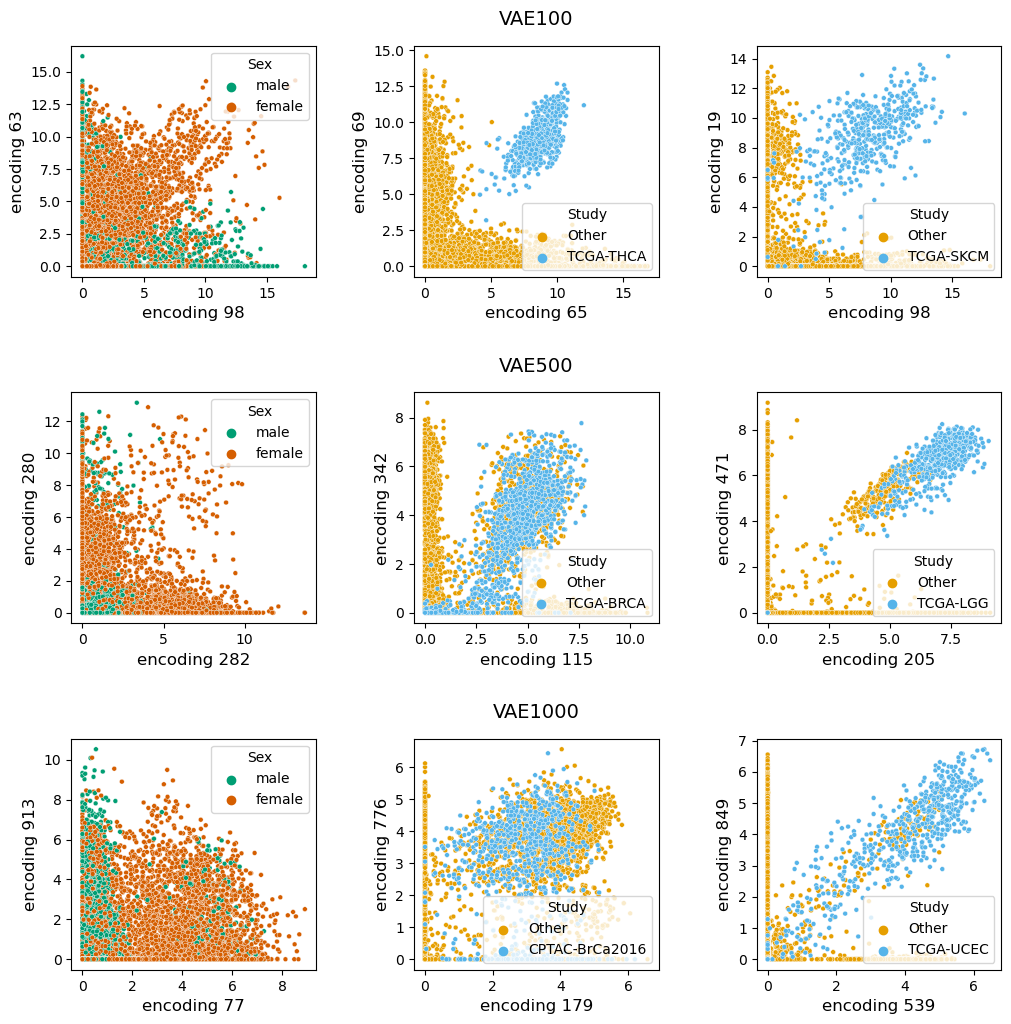

In [24]:
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':12, 'axes.spines.left': True, 'xtick.labelsize':10, 
                    'legend.fontsize':10}):
    figure, ax = plt.subplots(3, 3, figsize=(12, 12))
    plot_vae_encodings(vae100_sex_samples, gender_100_indices, ax[0, 0]) 
    plot_vae_encodings(vae500_sex_samples, gender_500_indices, ax[1, 0]) 
    plot_vae_encodings(vae1000_sex_samples, gender_1000_indices, ax[2, 0]) 
    plot_stat_test_for_cancer(vae100_study_samples, 'TCGA-THCA', ax[0, 1], title='VAE100')
    plot_stat_test_for_cancer(vae500_study_samples, 'TCGA-BRCA', ax[1, 1], title='VAE500')
    plot_stat_test_for_cancer(vae1000_study_samples, 'CPTAC-BrCa2016', ax[2, 1], title='VAE1000')
    plot_stat_test_for_cancer(vae100_study_samples, 'TCGA-SKCM', ax[0, 2])
    plot_stat_test_for_cancer(vae500_study_samples, 'TCGA-LGG', ax[1, 2])
    plot_stat_test_for_cancer(vae1000_study_samples, 'TCGA-UCEC', ax[2, 2])

    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    plt.show()
    figure.savefig(get_figure_path('FigureS3.png'), bbox_inches='tight', dpi=300);
    figure.savefig(get_figure_path('FigureS3.svg'), bbox_inches='tight', dpi=300);